In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from CameraYOLO import RadarCameraYoloDataset, CameraYOLO

model = CameraYOLO(num_classes=7)

/opt/conda/envs/rcfd/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on CPU mode only
*************Training started!*************


/opt/conda/envs/rcfd/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch [1/100], Step [0/18], Class Loss: 1.9521, BBox Loss: 0.3836, Objectness Loss: 0.9200, Total Loss: 3.2557
Epoch [1/100], Step [5/18], Class Loss: 1.8756, BBox Loss: 0.3135, Objectness Loss: 0.8842, Total Loss: 3.0733
Epoch [1/100], Step [10/18], Class Loss: 1.8199, BBox Loss: 0.2304, Objectness Loss: 0.8883, Total Loss: 2.9385
Epoch [1/100], Step [15/18], Class Loss: 1.7841, BBox Loss: 0.1920, Objectness Loss: 0.8745, Total Loss: 2.8506
Epoch 1 Completed - Class Loss: 1.8442, BBox Loss: 0.2843, Objectness Loss: 0.8742
Validation - Epoch 1, Class Loss: 1.6125, BBox Loss: 0.1836, Objectness Loss: 0.8147
Validation - mAP@50: 0.0000, mAP@75: 0.0000
Epoch [2/100], Step [0/18], Class Loss: 1.7534, BBox Loss: 0.1690, Objectness Loss: 0.8194, Total Loss: 2.7418
Epoch [2/100], Step [5/18], Class Loss: 1.7044, BBox Loss: 0.1386, Objectness Loss: 0.7960, Total Loss: 2.6391
Epoch [2/100], Step [10/18], Class Loss: 1.6904, BBox Loss: 0.1337, Objectness Loss: 0.8419, Total Loss: 2.6660
Epoch [2

In [2]:
#model.load_state_dict(torch.load("./trained_model_cam.pth"))
model.load_state_dict(torch.load("./trained_model_cam.pth"))
model.eval()

CameraYOLO(
  (camera_stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): CSPBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bottlenecks): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (final_conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1

In [3]:
from WaterScenes.radar_map_generate import RESOLUTION

# ✅ Load dataset
data_root = "/workspaces/Radar-Camera-Fusion-Detection/WaterScenes/sample_dataset"  # data path
input_shape = (RESOLUTION, RESOLUTION)

dataset = RadarCameraYoloDataset(data_root=data_root, input_shape=input_shape)

In [4]:
from torchvision import ops
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# YOLO style color
def color_list():
    hex = (
        '7FFF00',  # yellow green,
        '808080',  # grey  
        'FF4C4C',  # red      
        '32CD32',  # green  
        '1E90FF',  # blue 
        '9370DB',  # purple  
        'FF69B4',  # pink  
    )


    return [tuple(int(h[i:i + 2], 16) for i in (0, 2, 4)) for h in hex]

COLORS = color_list()

# YOLO style bbox drawing
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # copy
    img_copy = img.copy()

    # thickness adjusted by image size
    tl = max(1, int(min(img_copy.shape[:2]) / 400))
    
    # set color
    color = color or COLORS[int(label) % len(COLORS)]
    color = tuple(map(int, color))


    # RGB → BGR
    if img_copy.shape[-1] == 3:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)

    # coord
    x1, y1, x2, y2 = map(int, x)
    # draw bbox
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness=tl, lineType=cv2.LINE_AA)

    if label:
        # font size
        tf = max(tl - 1, 1)  # font thickness
        font_scale = tl / 5
        t_size = cv2.getTextSize(label, 0, fontScale=font_scale, thickness=tf)[0]
        c2 = x1 + t_size[0], y1 - t_size[1] - 3
        cv2.rectangle(img_copy, (x1, y1), c2, color, -1, cv2.LINE_AA)  # Filled background

        # add text
        cv2.putText(img_copy, label, (x1, y1 - 2), 0, font_scale, (255, 255, 255), thickness=tf, lineType=cv2.LINE_AA)

    return cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB) 


# xywh → xyxy
def xywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y


In [13]:
# Visualization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
def visualize_predictions(model, dataset, num_samples=5, confidence_threshold=0.5, iou_threshold=0.4):
    model.eval()
    
    for i in range(num_samples):
        # ========= Tensor → numpy =========
        image, _ , labels = dataset[i]
        if isinstance(image, torch.Tensor):
            image_np = image.permute(1,2,0).cpu().numpy() # image_np: (3, 160, 160)
            image_np = (image_np * np.array(STD, dtype=np.float32)) + np.array(MEAN, dtype=np.float32)
            image_np = (image_np * 255).astype(np.uint8)  # float → uint8
        else:
            image_np = image.copy()

        if image_np.shape[-1] == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        #print(f"image_np: {image_np.shape}")
 
        # ========= Prediction =========
        with torch.no_grad():
            class_output, bbox_output, obj_output = model(image.unsqueeze(0))

        class_prob = torch.softmax(class_output, dim=1)
        confidence, pred_classes = torch.max(class_prob, dim=1)
        if isinstance(bbox_output, torch.Tensor):
            pred_boxes = bbox_output.squeeze(0).cpu().numpy().reshape(-1, 4)

            objectness = obj_output.squeeze(0).cpu().numpy().flatten()
            conf_scores = (confidence.squeeze(0).cpu().numpy().flatten()) * objectness
            pred_classes = pred_classes.squeeze(0).cpu().numpy().flatten()
            
        else:
            pred_boxes = bbox_output.reshape(-1, 4)
            conf_scores = confidence.flatten() * obj_output.flatten()
            pred_classes = pred_classes.flatten()

        #print(f"Number of predicted boxes: {len(pred_boxes)}")

        # ========= NMS =========
        if len(pred_boxes) > 0:
            pred_boxes_tensor = torch.tensor(pred_boxes, dtype=torch.float32)
            conf_scores_tensor = torch.tensor(conf_scores, dtype=torch.float32)
            nms_indices = ops.nms(pred_boxes_tensor, conf_scores_tensor, iou_threshold)

            pred_boxes = xywh2xyxy(pred_boxes_tensor[nms_indices]).numpy()
            pred_boxes = pred_boxes_tensor[nms_indices].numpy()
            #print(f"pred_boxes: {pred_boxes}")
            conf_scores = conf_scores_tensor[nms_indices]
            pred_classes = pred_classes[nms_indices]

        #print(f"Number of predicted boxes after NMS: {len(pred_boxes)}")

        # ========= Ground Truth =========
        gt_img = image_np.copy()
        pred_img = image_np.copy()
        
        if labels.size(0) > 0:
            gt_boxes = xywh2xyxy(labels[:, 1:5])
            for j, box in enumerate(gt_boxes):
                box = box.numpy()
                #print(f"box: {box}")
                class_id = int(labels[j][0])
                label = f"GT: {class_id}"
                gt_box = box * [image_np.shape[1], image_np.shape[0], image_np.shape[1], image_np.shape[0]]
                gt_img = plot_one_box(gt_box, gt_img, color=COLORS[int(class_id % len(COLORS))], label=label)

        if len(pred_boxes) > 0:
            for j in range(pred_boxes.shape[0]):
                if conf_scores[j] > confidence_threshold:
                    #print(f"pred_boxes[j]:{pred_boxes[j]}")
                    pred_box = pred_boxes[j] * np.array([image_np.shape[1], image_np.shape[0], image_np.shape[1], image_np.shape[0]])
                    # print(f"pred_box: {pred_box}")
                    label = f"Pred: {class_id} ({conf_scores[j]:.2f})"
                    pred_img = plot_one_box(pred_box, pred_img, color=COLORS[class_id % len(COLORS)], label=label)

        # ========= Visualization =========
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))

        # GT Plot
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB) 
        axs[0].imshow(gt_img)
        axs[0].set_title("Ground Truth")
        axs[0].axis('off')

        # Prediction Plot
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB) 
        axs[1].imshow(pred_img)
        axs[1].set_title("Prediction")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

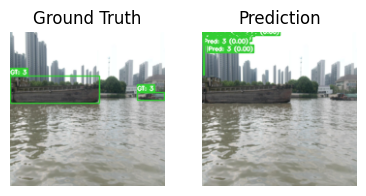

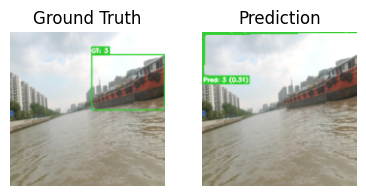

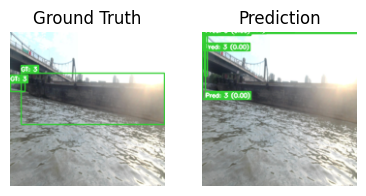

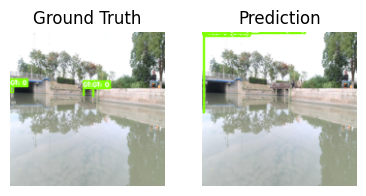

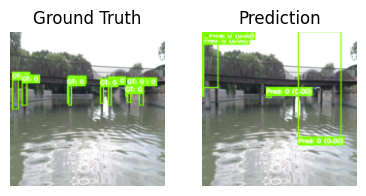

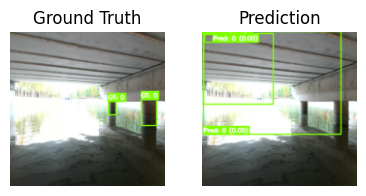

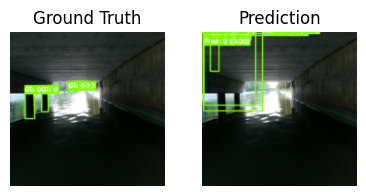

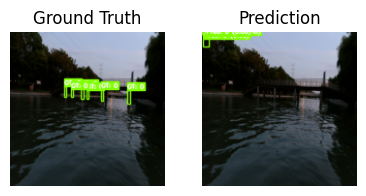

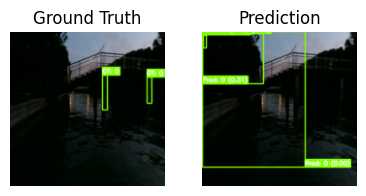

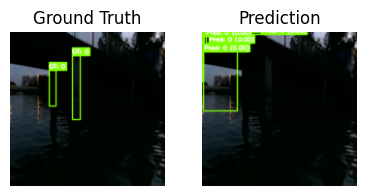

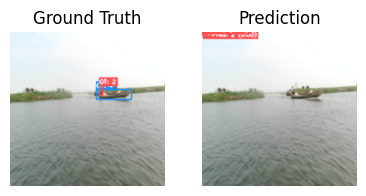

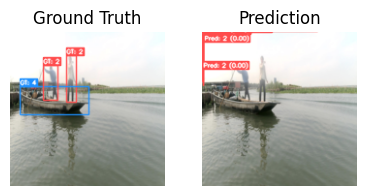

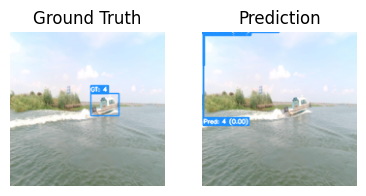

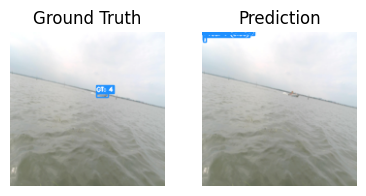

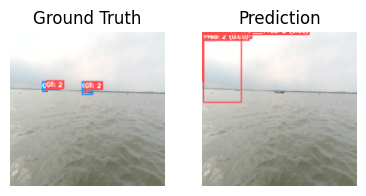

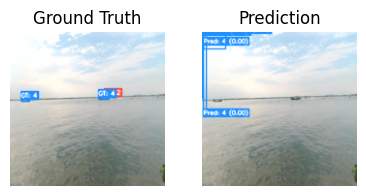

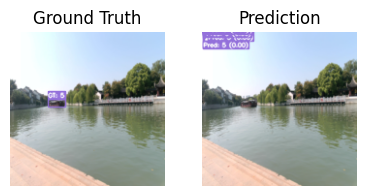

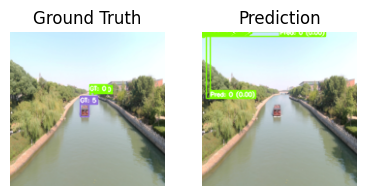

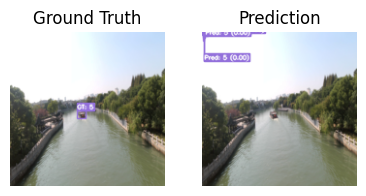

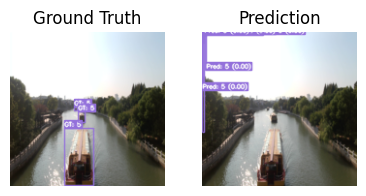

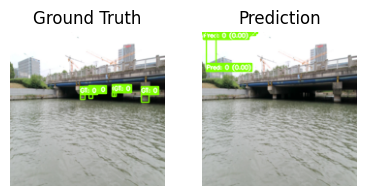

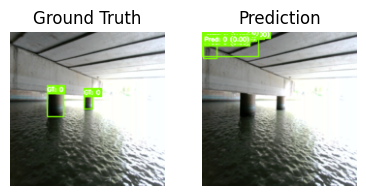

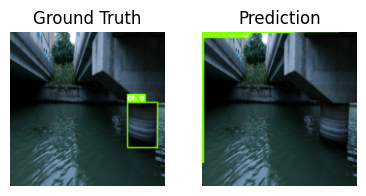

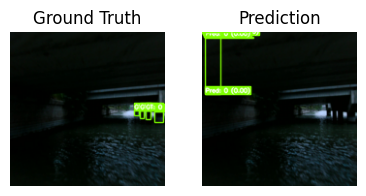

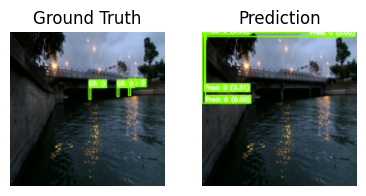

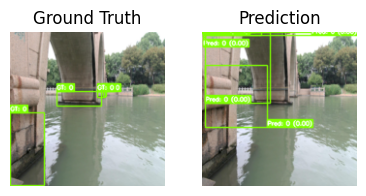

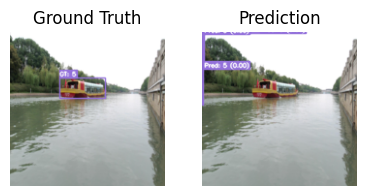

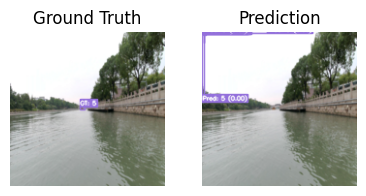

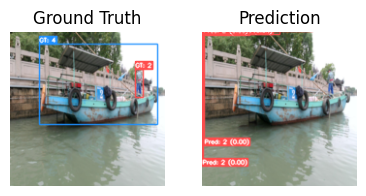

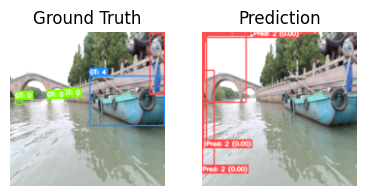

In [14]:
# viz example
visualize_predictions(model, dataset, num_samples=30, confidence_threshold=0.0, iou_threshold=0.9)